In [1]:
import os
import numpy as np
import healpy as hp
import pylab as plt
%matplotlib inline

import cv2

import csgan as cs

def ch_mkdir(directory):
    """
    ch_mkdir : This function creates a directory if it does not exist.

    Arguments:
        directory (string): Path to the directory.

    --------
    Returns:
        null.		
    """
    if not os.path.exists(directory):
          os.makedirs(directory)

def canny(d_in,R,meth,edd):
    d = d_in
    if (R!=0):
        dt = np.fft.fft2(d)
        if meth=='g':
            for i in range(sz):
                for j in range(sz):
                    k2 = 1.*(i*i+j*j)/d.shape[0]
                    dt[i,j]=dt[i,j]*np.exp(-k2*R*R/2)

        if meth=='tp':
            for i in range(sz):
                for j in range(sz):
                    k = np.sqrt(0.001+i*i+j*j)/sz
                    dt[i,j]=dt[i,j]* 3*(np.sin(k*R)-k*R*np.cos(k*R))/(k*R)**3

        d = np.fft.ifft2(dt)
        d = abs(d)

    if edd=='lap':
        d = cv2.Laplacian(d,cv2.CV_64F)

    if edd=='sob':
        sobelx = cv2.Sobel(d,cv2.CV_64F,1,0,ksize=3)
        sobely = cv2.Sobel(d,cv2.CV_64F,0,1,ksize=3)
        d =np.sqrt(sobelx**2+sobely**2)

    if edd=='sch':
        scharrx = cv2.Scharr(d,cv2.CV_64F,1,0)
        scharry = cv2.Scharr(d,cv2.CV_64F,0,1)
        d =np.sqrt(scharrx**2+scharry**2)
        
    return d

def filt_all(maps,func):
    out1 = []
    for m in maps:
        out1.append(func(m))
        
    return np.stack([maps,np.array(out1)],axis=3)

def func(dt):
    return canny(dt,0,'none','sch')

In [2]:
dp = cs.Data_Provider('../../dataset/map1n_allz_rtaapixlw_2048_3.fits')

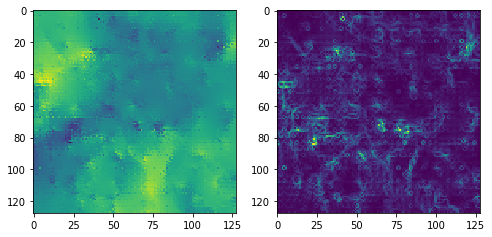

In [3]:
dt = filt_all(dp(10,128),func)
dt.shape
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,18))
ax1.imshow(dt[0,:,:,0])
ax2.imshow(dt[0,:,:,1])

In [4]:
# m = hp.read_map('../strings/map1n_allz_rtaapixlw_4096_1b'
#                  ,dtype=np.float16,verbose=0,nest=1)
# hp.mollview(m, title="Mollview image RING",nest=1)

In [42]:
from __future__ import division
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
from six.moves import xrange

from csgan.ops import *
from csgan.utils import *

from csgan import Data_Provider 


def conv_out_size_same(size, stride):
    return int(math.ceil(float(size) / float(stride)))


class DCGAN(object):
    def __init__(self, data_provider, batch_size=64, n_side=4, 
                 output_height=None, output_width=None,
                 z_dim=100, gf_dim=64, df_dim=64,
                 gfc_dim=1024, dfc_dim=1024,
                 label_real_lower=0.99,label_fake_upper=0.01,
                 checkpoint_dir=None,save_per = 500):

        self.dp = data_provider

        """

        Args:
          sess: TensorFlow session
          batch_size: The size of batch. Should be specified before training.
          y_dim:(optional) Dimension of dim for y. [None]
          z_dim:(optional) Dimension of dim for Z. [100]
          gf_dim:(optional) Dimension of gen filters in first conv layer. [64]
          df_dim:(optional) Dimension of discrim filters in first conv layer. [64]
          gfc_dim:(optional) Dimension of gen units for for fully connected layer. [1024]
          dfc_dim:(optional) Dimension of discrim units for fully connected layer. [1024]
          c_dim:(optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
        tf.reset_default_graph()
#        run_config = tf.ConfigProto ()
        self.sess = tf.Session()

        self.batch_size = batch_size
        self.n_side = n_side
        self.n_sample = self.n_side**2
        self.label_real_lower = label_real_lower
        self.label_fake_upper = label_fake_upper
        self.save_per = save_per
        
        x = self.dp(1)
        self.input_height,self.input_width, self.c_dim = x.shape[1:4]
        if output_height is None or output_width is None:
            print("Output size is same as input's!")
            self.output_height = self.input_height
            self.output_width = self.input_width           
        else:
            self.output_height = output_height
            self.output_width = output_width

        # self.y_dim = y_dim
        self.z_dim = z_dim

        self.gf_dim = gf_dim
        self.df_dim = df_dim

        self.gfc_dim = gfc_dim
        self.dfc_dim = dfc_dim

        # batch normalization : deals with poor initialization helps gradient flow
        self.d_bn1 = batch_norm(name='d_bn1')
        self.d_bn2 = batch_norm(name='d_bn2')
        self.d_bn3 = batch_norm(name='d_bn3')

        self.g_bn0 = batch_norm(name='g_bn0')
        self.g_bn1 = batch_norm(name='g_bn1')
        self.g_bn2 = batch_norm(name='g_bn2')
        self.g_bn3 = batch_norm(name='g_bn3')

        self.checkpoint_dir = checkpoint_dir

        self.build_model()

    def build_model(self):
        image_dims = [self.input_height, self.input_width, self.c_dim]

        self.inputs = tf.placeholder(tf.float32, [self.batch_size] + image_dims, name='real_images')

        inputs = self.inputs

        self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')
        self.z_sum = histogram_summary("z", self.z)

        self.G = self.generator(self.z,self.batch_size)
        self.D, self.D_logits = self.discriminator(inputs, reuse=False)
        self.sampler_out = self.sampler(self.z,self.n_sample)
        self.D_, self.D_logits_ = self.discriminator(self.G, reuse=True)

        self.d_sum = histogram_summary("d", self.D)
        self.d__sum = histogram_summary("d_", self.D_)
        self.REAL_sum = image_summary("Real", inputs[:3, :, :, :1])
        self.G_sum = image_summary("G", self.G[:, :, :, :1])

        def sigmoid_cross_entropy_with_logits(x, y):
            try:
                return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)
            except:
                return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, targets=y)

        # self.d_loss_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(self.D_logits, tf.ones_like(self.D)))
        # self.d_loss_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(self.D_logits_, tf.zeros_like(self.D_)))
        # self.g_loss = tf.reduce_mean(sigmoid_cross_entropy_with_logits(self.D_logits_, tf.ones_like(self.D_)))

        rv_shape = self.D.shape
        self.d_loss_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(self.D_logits, tf.ones_like(self.D) *
                                                            tf.random_uniform(rv_shape,self.label_real_lower,1.0)))
        self.d_loss_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(self.D_logits_, tf.ones_like(self.D_) *
                                                            tf.random_uniform(rv_shape,0.0,self.label_fake_upper)))
        self.g_loss = tf.reduce_mean(sigmoid_cross_entropy_with_logits(self.D_logits_, tf.ones_like(self.D_) * 
                                                            tf.random_uniform(rv_shape,self.label_real_lower,1.0)))

        self.d_loss_real_sum = scalar_summary("d_loss_real", self.d_loss_real)
        self.d_loss_fake_sum = scalar_summary("d_loss_fake", self.d_loss_fake)

        self.d_loss = self.d_loss_real + self.d_loss_fake

        self.g_loss_sum = scalar_summary("g_loss", self.g_loss)
        self.d_loss_sum = scalar_summary("d_loss", self.d_loss)

        t_vars = tf.trainable_variables()

        self.d_vars = [var for var in t_vars if 'd_' in var.name]
        self.g_vars = [var for var in t_vars if 'g_' in var.name]

        self.saver = tf.train.Saver()

    def train(self,learning_rate=0.0002,beta1=0.5,num_epoch=25,
              batch_per_epoch = 1000,sample_per=None,
              sample_dir='samples',checkpoint_dir='checkpoint'):
        
        if sample_per is None:
            sample_per = batch_per_epoch
            
        d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(self.d_loss,var_list=self.d_vars)
        g_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(self.g_loss,var_list=self.g_vars)
        try:
#             self.sess.run(tf.global_variables_initializer())
            tf.global_variables_initializer().run(session=self.sess)
        except:
#             self.sess.run(tf.initialize_all_variables())
            tf.initialize_all_variables().run(session=self.sess)

        self.g_sum = merge_summary([self.z_sum, self.d__sum, self.G_sum, self.d_loss_fake_sum, self.g_loss_sum])
        self.d_sum = merge_summary([self.z_sum, self.d_sum, self.REAL_sum, self.d_loss_real_sum, self.d_loss_sum])
        self.writer = SummaryWriter("./logs", self.sess.graph)

        # sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
        sample_z = np.random.normal(size=(self.n_sample, self.z_dim))
        
        sample = self.dp(self.n_sample)

        counter = 1
        start_time = time.time()
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            counter = checkpoint_counter
            print(" [*] Load SUCCESS")
        else:
            print(" [!] Load failed...")

        for epoch in xrange(num_epoch):

            for idx in xrange(batch_per_epoch):
                batch = self.dp(self.batch_size)
                batch_images = np.array(batch).astype(np.float32)

                batch_z = np.random.normal(size=(self.batch_size, self.z_dim)).astype(np.float32)
                # Update D network
                _, summary_str = self.sess.run([d_optim, self.d_sum],feed_dict={self.inputs: batch_images, self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

                # Update G network
                _, summary_str = self.sess.run([g_optim, self.g_sum], feed_dict={self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

                # Run g_optim twice to make sure that d_loss does not go to zero(different from paper)
                _, summary_str = self.sess.run([g_optim, self.g_sum], feed_dict={self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

#                 errD_fake = self.d_loss_fake.eval(session=self.sess,{self.z: batch_z})
#                 errD_real = self.d_loss_real.eval(session=self.sess,{self.inputs: batch_images})
#                 errG = self.g_loss.eval(session=self.sess,{self.z: batch_z})
                errD_fake = self.sess.run(self.d_loss_fake,{self.z: batch_z})
                errD_real = self.sess.run(self.d_loss_real,{self.inputs: batch_images})
                errG = self.sess.run(self.g_loss,{self.z: batch_z})

                counter += 1
                print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                      %(epoch, idx, batch_per_epoch, time.time() - start_time, errD_fake + errD_real, errG))

                if np.mod(counter, sample_per) == 1:
#                     try:
                        samples = self.sess.run(self.sampler_out,
                            feed_dict={self.z: sample_z})

                        ch_mkdir(sample_dir)
                        
                        save_images(samples[:,:,:,:1], image_manifold_size(samples.shape[0]),
                                     './{}/train_{:02d}_{:04d}.png'.format(sample_dir, epoch, idx))
                        print('./{}/train_{:02d}_{:04d}.png'.format(sample_dir, epoch, idx))
#                     except:
#                         print("one pic error!...")

                if np.mod(counter, self.save_per) == 2:
                    self.save(checkpoint_dir, counter)

    def discriminator(self, image, reuse=False):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()

            h0 = lrelu(conv2d(image, self.df_dim, name='d_h0_conv'))
            h1 = lrelu(self.d_bn1(conv2d(h0, self.df_dim * 2, name='d_h1_conv')))
            h2 = lrelu(self.d_bn2(conv2d(h1, self.df_dim * 4, name='d_h2_conv')))
            h3 = lrelu(self.d_bn3(conv2d(h2, self.df_dim * 8, name='d_h3_conv')))
            h4 = linear(tf.reshape(h3, [self.batch_size, -1]), 1, 'd_h4_lin')

            return tf.nn.sigmoid(h4), h4

    def generator(self, z, batch_size, mode='train'):
        with tf.variable_scope("generator") as scope:
            if mode=='train':
                trainable = True
                pass
            elif mode=='sampler':
                trainable = False
                scope.reuse_variables()
            else:
                assert 0,'Unkown mode for generator.'

            s_h, s_w = self.output_height, self.output_width
            s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
            s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
            s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
            s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

            assert s_h16*s_w16*self.gf_dim*8==z.shape[1],str(s_h16*s_w16*self.gf_dim*8)+' != '+str(z.shape[1])

            # project `z` and reshape
            self.z_, self.h0_w, self.h0_b = linear(z, self.gf_dim * 8 * s_h16 * s_w16, 'g_h0_lin', with_w=True)
            self.h0 = tf.reshape(self.z_, [batch_size, s_h16, s_w16, self.gf_dim * 8])
            h0 = tf.nn.relu(self.g_bn0(self.h0, train=trainable))

            self.h1, self.h1_w, self.h1_b = deconv2d(h0, [batch_size, s_h8, s_w8, self.gf_dim * 4], name='g_h1', with_w=True)
            h1 = tf.nn.relu(self.g_bn1(self.h1, train=trainable))

            h2, self.h2_w, self.h2_b = deconv2d(h1, [batch_size, s_h4, s_w4, self.gf_dim * 2], name='g_h2', with_w=True)
            h2 = tf.nn.relu(self.g_bn2(h2, train=trainable))

            h3, self.h3_w, self.h3_b = deconv2d(h2, [batch_size, s_h2, s_w2, self.gf_dim * 1], name='g_h3', with_w=True)
            h3 = tf.nn.relu(self.g_bn3(h3, train=trainable))

            h4, self.h4_w, self.h4_b = deconv2d(h3, [batch_size, s_h, s_w, self.c_dim], name='g_h4', with_w=True)

            return tf.nn.tanh(h4)
        
    def generate(self, z):
        
        n_sample = z.shape[0]
        output = self.generator(self.z, n_sample, mode='sampler')
        samples = self.sess.run(output,feed_dict={self.z: z})
        
        return samples
    
    def sampler(self, z, n_sample):
        
        return self.generator(z, n_sample, mode='sampler')
        
#         with tf.variable_scope("generator") as scope:
#             scope.reuse_variables()

#             s_h, s_w = self.output_height, self.output_width
#             s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
#             s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
#             s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
#             s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

#             assert s_h16*s_w16*self.gf_dim*8==z.shape[1],str(s_h16*s_w16*self.gf_dim*8)+' != '+str(z.shape[1])
#             # project `z` and reshape
#             h0 = tf.reshape(
#                 linear(z, self.gf_dim * 8 * s_h16 * s_w16, 'g_h0_lin'),
#                 [-1, s_h16, s_w16, self.gf_dim * 8])
#             h0 = tf.nn.relu(self.g_bn0(h0, train=False))

#             h1 = deconv2d(h0, [self.batch_size, s_h8, s_w8, self.gf_dim * 4], name='g_h1')
#             h1 = tf.nn.relu(self.g_bn1(h1, train=False))

#             h2 = deconv2d(h1, [self.batch_size, s_h4, s_w4, self.gf_dim * 2], name='g_h2')
#             h2 = tf.nn.relu(self.g_bn2(h2, train=False))

#             h3 = deconv2d(h2, [self.batch_size, s_h2, s_w2, self.gf_dim * 1], name='g_h3')
#             h3 = tf.nn.relu(self.g_bn3(h3, train=False))

#             h4 = deconv2d(h3, [self.batch_size, s_h, s_w, self.c_dim], name='g_h4')

#             return tf.nn.tanh(h4)

    @property
    def model_dir(self):
        return "{}_{}".format(self.output_height, self.output_width)

    def save(self, checkpoint_dir, step):
        model_name = "DCGAN.model"
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,
                         os.path.join(checkpoint_dir, model_name),
                         global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0

In [43]:
image_size = 64

def dpp(n):
#     return dp(n,image_size).reshape(n,image_size,image_size,1)
    return filt_all(dp(n,image_size),func)

# run_config.gpu_options.allow_growth = True

dcgan = DCGAN(
    data_provider = dpp,
    batch_size=17,
    gf_dim=16, df_dim=64,
    gfc_dim=1024, dfc_dim=1024,
    z_dim=2048,
    checkpoint_dir='checkpoint')

dcgan.train(num_epoch=1,batch_per_epoch = 2)

Output size is same as input's!
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/64_64/DCGAN.model-2
 [*] Success to read DCGAN.model-2
 [*] Load SUCCESS
Epoch: [ 0] [   0/   2] time: 4.0881, d_loss: 8.25578308, g_loss: 0.04221733
./samples/train_00_0000.png
Epoch: [ 0] [   1/   2] time: 8.1012, d_loss: 4.33625746, g_loss: 0.03550571


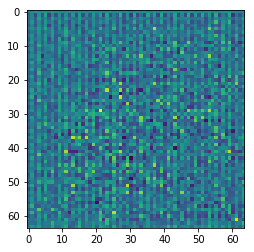

In [27]:
sample_z = np.random.normal(size=(5, dcgan.z_dim))
plt.imshow(dcgan.generate(sample_z)[0,:,:,0])

In [90]:
# 			self.saver.restore(self.sess, model_add+'/model')
# 		else:
# 			init = tf.global_variables_initializer()
# 			self.sess.run(init)

# 	def restore(self):
# 		tf.reset_default_graph()
# 		self.saver.restore(self.sess, self.model_add+'/model')

def ch_mkdir(directory):
    """
    ch_mkdir : This function creates a directory if it does not exist.

    Arguments:
        directory (string): Path to the directory.

    --------
    Returns:
        null.		
    """
    if not os.path.exists(directory):
          os.makedirs(directory)
saver = tf.train.Saver()
ch_mkdir('model')
saver.save(sess, 'model/model')

'model/model'

In [12]:
help(tf.random_uniform)

Help on function random_uniform in module tensorflow.python.ops.random_ops:

random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)
    Outputs random values from a uniform distribution.
    
    The generated values follow a uniform distribution in the range
    `[minval, maxval)`. The lower bound `minval` is included in the range, while
    the upper bound `maxval` is excluded.
    
    For floats, the default range is `[0, 1)`.  For ints, at least `maxval` must
    be specified explicitly.
    
    In the integer case, the random integers are slightly biased unless
    `maxval - minval` is an exact power of two.  The bias is small for values of
    `maxval - minval` significantly smaller than the range of the output (either
    `2**32` or `2**64`).
    
    Args:
      shape: A 1-D integer Tensor or Python array. The shape of the output tensor.
      minval: A 0-D Tensor or Python value of type `dtype`. The lower bound on the
        range of random val